# ResNet50 Implementation

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.initializers import glorot_uniform
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import to_categorical
import h5py
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR) # suppress tensorflow deprecation warnings
print(K.tensorflow_backend._get_available_gpus()) # gpu check

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


## ResNet50

In [2]:
def identity_block(X, f, filters, stage, block):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    # Shortcut
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', padding='same', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2,2), padding='same', name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

## Fully Connected Network(FCN) 50 layers

In [3]:
def FCN50(input_shape=(64, 64, 3), classes=6, nodes=512):
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    
    # Hidden Layer
    for _ in range(49):
        X = Dense(nodes, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X)
        X = Dropout(0.3)(X)
    
    # Output Layer
    X = Dense(classes, activation='softmax')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='FCN50')
    
    return model

## Plain Convolutional Neural Network(CNN)

In [4]:
def plain_block(X, f, filters, stage, block, s=(1, 1)):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = s, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X = Activation('relu')(X)
    
    return X

def CNN(input_shape=(64, 64, 3), classes=6):
    X_input = Input(input_shape)
    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', padding='same', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = plain_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = plain_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = plain_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = plain_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = plain_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = plain_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = plain_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = plain_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = plain_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = plain_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = plain_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = plain_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = plain_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = plain_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = plain_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = plain_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AveragePooing
    X = AveragePooling2D((2,2), padding='same', name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='Plain CNN')
    
    return model

## Load Datasets

### Sign Gesture

In [5]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert to categorical
Y_train = to_categorical(Y_train_orig)[0]
Y_test = to_categorical(Y_test_orig)[0]


print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### CIFAR-10

In [5]:
# Load data and preprocess
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data() # load CIFAR-10 data

X_train = X_train.reshape((50000, 32, 32, 3)) # Reshape to get third dimension
X_train = X_train.astype('float32') / 255 # Normalize between 0 and 1

X_test = X_test.reshape((10000, 32, 32, 3)) # Reshape to get third dimension
X_test = X_test.astype('float32') / 255 # Normalize between 0 and 1

# Convert labels to categorical data
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


## Global Configuration

In [6]:
input_shape = X_train[0].shape
classes = Y_train.shape[1]
epochs = 100
batch_size = 32

## Fitting ResNet50

In [5]:
resnet = ResNet50(input_shape=input_shape, classes=classes)
resnet.summary()
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [6]:
history_resnet = resnet.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)
test_loss, test_acc = resnet.evaluate(X_test, Y_test)
print("Test loss =", test_loss)
print("Test accuracy =", test_acc)
resnet.save('./models/ResNet50.h5')
del resnet
with open('./history/resnet_history', 'wb') as file_pi:
    pickle.dump(history_resnet.history, file_pi)

Epoch 1/100
50000/50000 [==============================] - 389s 8ms/step - loss: 2.3374 - accuracy: 0.2944
Epoch 2/100
50000/50000 [==============================] - 366s 7ms/step - loss: 2.2102 - accuracy: 0.3272
Epoch 3/100
50000/50000 [==============================] - 368s 7ms/step - loss: 1.9431 - accuracy: 0.3838
Epoch 4/100
50000/50000 [==============================] - 365s 7ms/step - loss: 1.8543 - accuracy: 0.4319
Epoch 5/100
50000/50000 [==============================] - 364s 7ms/step - loss: 1.6811 - accuracy: 0.4773
Epoch 6/100
50000/50000 [==============================] - 370s 7ms/step - loss: 1.7434 - accuracy: 0.4393
Epoch 7/100
50000/50000 [==============================] - 372s 7ms/step - loss: 1.6007 - accuracy: 0.4741
Epoch 8/100
50000/50000 [==============================] - 366s 7ms/step - loss: 1.4642 - accuracy: 0.5249
Epoch 9/100
50000/50000 [==============================] - 367s 7ms/step - loss: 1.3969 - accuracy: 0.5360
Epoch 10/100
50000/50000 [===========

## Fitting FCN

In [8]:
fcn = FCN50(input_shape=input_shape, classes=classes, nodes=584)
fcn.summary()
fcn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "FCN50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 584)               1794632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 584)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 584)               341640    
_________________________________________________________________
dropout_2 (Dropout)          (None, 584)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 584)               341640

In [9]:
history_fcn = fcn.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)
test_loss, test_acc = fcn.evaluate(X_test, Y_test)
print("Test loss =", test_loss)
print("Test accuracy =", test_acc)
fcn.save('./models/FCN50.h5')
del fcn
with open('./history/fcn50_history', 'wb') as file_pi:
    pickle.dump(history_fcn.history, file_pi)

Epoch 1/100
50000/50000 [==============================] - 102s 2ms/step - loss: 2.3033 - accuracy: 0.1005
Epoch 2/100
50000/50000 [==============================] - 98s 2ms/step - loss: 2.3028 - accuracy: 0.0980
Epoch 3/100
50000/50000 [==============================] - 99s 2ms/step - loss: 2.3028 - accuracy: 0.0985
Epoch 4/100
50000/50000 [==============================] - 100s 2ms/step - loss: 2.3028 - accuracy: 0.0984
Epoch 5/100
50000/50000 [==============================] - 100s 2ms/step - loss: 2.3027 - accuracy: 0.0996
Epoch 6/100
50000/50000 [==============================] - 98s 2ms/step - loss: 2.3028 - accuracy: 0.0983
Epoch 7/100
50000/50000 [==============================] - 98s 2ms/step - loss: 2.3028 - accuracy: 0.0983
Epoch 8/100
50000/50000 [==============================] - 100s 2ms/step - loss: 2.3028 - accuracy: 0.1009
Epoch 9/100
50000/50000 [==============================] - 99s 2ms/step - loss: 2.3028 - accuracy: 0.0982
Epoch 10/100
50000/50000 [================

## Fitting Plain CNN

In [7]:
cnn = CNN(input_shape=input_shape, classes=classes)
cnn.summary()
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "Plain CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 16, 16, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
res2a_branch2a (Conv2D)      (None, 7, 7, 64)          4160      
_________________________________________________________________
bn2a_branch2a (BatchNormaliz (None, 7, 7, 64)          25

In [8]:
history_cnn = cnn.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)
test_loss, test_acc = cnn.evaluate(X_test, Y_test)
print("Test loss =", test_loss)
print("Test accuracy =", test_acc)
cnn.save('./models/CNN.h5')
del cnn
with open('./history/cnn_history', 'wb') as file_pi:
    pickle.dump(history_cnn.history, file_pi)

Epoch 1/100
50000/50000 [==============================] - 324s 6ms/step - loss: 2.3172 - accuracy: 0.1652
Epoch 2/100
50000/50000 [==============================] - 301s 6ms/step - loss: 2.3158 - accuracy: 0.1607
Epoch 3/100
50000/50000 [==============================] - 301s 6ms/step - loss: 2.2950 - accuracy: 0.1600
Epoch 4/100
50000/50000 [==============================] - 301s 6ms/step - loss: 2.3087 - accuracy: 0.1530
Epoch 5/100
50000/50000 [==============================] - 300s 6ms/step - loss: 2.1175 - accuracy: 0.2035
Epoch 6/100
50000/50000 [==============================] - 301s 6ms/step - loss: 2.2098 - accuracy: 0.1787
Epoch 7/100
50000/50000 [==============================] - 298s 6ms/step - loss: 2.0900 - accuracy: 0.2003
Epoch 8/100
50000/50000 [==============================] - 300s 6ms/step - loss: 2.1246 - accuracy: 0.1952
Epoch 9/100
50000/50000 [==============================] - 300s 6ms/step - loss: 2.0430 - accuracy: 0.2104
Epoch 10/100
50000/50000 [===========

## Load History

In [9]:
with open('./history/resnet_history', 'rb') as f:
    history_resnet = pickle.load(f)
with open('./history/fcn50_history', 'rb') as f:
    history_fcn = pickle.load(f)
with open('./history/cnn_history', 'rb') as f:
    history_cnn = pickle.load(f)

## Plot Loss

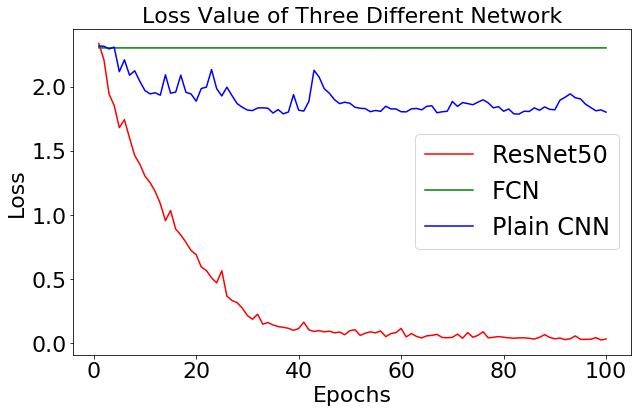

In [10]:
loss_resnet = history_resnet['loss']
loss_fcn = history_fcn['loss']
loss_cnn = history_cnn['loss']
epochs = range(1, len(loss_resnet) + 1)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(epochs, loss_resnet, 'r', label='ResNet50')
ax.plot(epochs, loss_fcn, 'g', label='FCN')
ax.plot(epochs, loss_cnn, 'b', label='Plain CNN')
ax.set_title('Loss Value of Three Different Network', fontsize=22)
ax.set_xlabel(r'Epochs', fontsize=22)
ax.set_ylabel(r'Loss', fontsize=22)
ax.tick_params(labelsize=22)

ax.legend(fontsize=24)

## Plot Accuracy

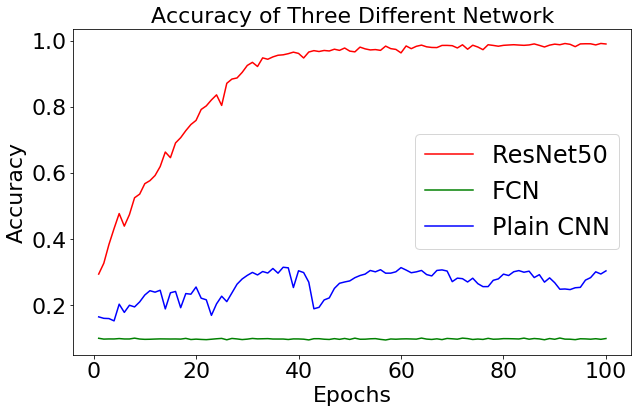

In [11]:
acc_resnet = history_resnet['accuracy']
acc_fcn = history_fcn['accuracy']
acc_cnn = history_cnn['accuracy']
epochs = range(1, len(acc_resnet) + 1)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(epochs, acc_resnet, 'r', label='ResNet50')
ax.plot(epochs, acc_fcn, 'g', label='FCN')
ax.plot(epochs, acc_cnn, 'b', label='Plain CNN')
ax.set_title('Accuracy of Three Different Network', fontsize=22)
ax.set_xlabel(r'Epochs', fontsize=22)
ax.set_ylabel(r'Accuracy', fontsize=22)
ax.tick_params(labelsize=22)

ax.legend(fontsize=24)

## We also changed the last Average Pooling layer to test the difference, but since it only changed one word, we would not paste the entire code section additionally